# Import packages

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
import shap
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

# Show plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# Set maximum number of columns to be displayed
pd.set_option('display.max_columns', 100)

# Import Pd Pickle Files

In [3]:
PICKLE_TRAIN_DIR = os.path.join("..", "featured_data", "train_data.pkl")
PICKLE_HISTORY_DIR = os.path.join("..", "featured_data", "hist_data.pkl")

data = pd.read_pickle(PICKLE_TRAIN_DIR)
hist_data = pd.read_pickle(PICKLE_HISTORY_DIR)

In [4]:
data.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,churn,tenure,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
0,48ada52261e7cf58715202705a0451c9,5.490346,0.000000,4.001128,4.423595,0.0,2.556652,0.095919,0.088347,58.995952,0,2.920541,-41.76,-41.76,0.301030,3.238889,1.236418,0,3,10.0,37.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,24011ae4ebbe3035111d65fa7c15bc57,4.327104,4.739944,0.000000,3.085953,0.0,0.444045,0.114481,0.098142,40.606701,1,0.000000,25.44,25.44,0.477121,2.832503,1.649802,1,3,5.0,2.0,6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,0.000000,16.38,16.38,0.301030,1.298635,1.170262,0,7,7.0,76.0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,0.000000,28.60,28.60,0.301030,0.880814,1.171902,0,6,3.0,68.0,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,0.000000,30.22,30.22,0.301030,1.422590,1.152288,0,6,2.0,69.0,9,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
hist_data.drop(columns=['churn'], inplace=True)
hist_data.head()

,id,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p1_fix,mean_year_price_p2
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,40.701732,24.524832
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,44.385450,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,45.319710,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,40.647427,24.486748
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,44.266930,0.000000


In [6]:
data = pd.merge(data, hist_data, on='id')

pd.DataFrame({"Dataframe columns": data.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


# Splitting Dataset

In [7]:
y= data["churn"]
X=data
X.drop(columns=['id', 'churn'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

# Algorithms Implementation

## =- Logistic Regression

In [140]:
LR_model = LogisticRegression().fit(X_train, y_train)
pred = LR_model.predict(X_test)
#LR_model.score(X_train, y_train)
acc = accuracy_score(y_test, pred)
print(acc)

0.8968687872763419


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [141]:
print("Classification Report :")
print(classification_report(y_test,pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3609
           1       0.00      0.00      0.00       415

    accuracy                           0.90      4024
   macro avg       0.45      0.50      0.47      4024
weighted avg       0.80      0.90      0.85      4024



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


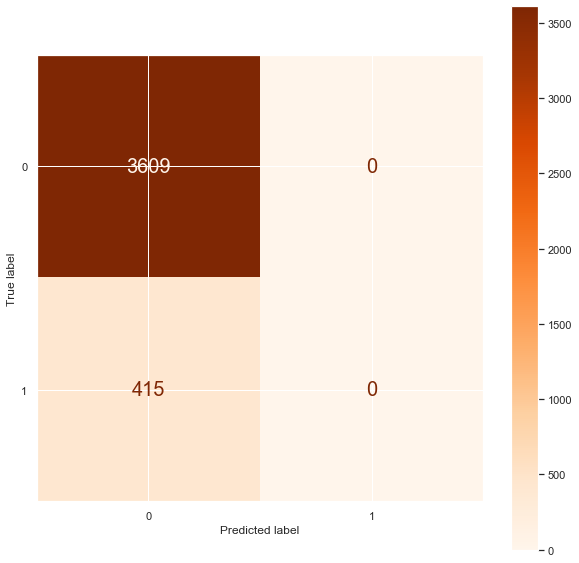

In [142]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(LR_model, X_test, y_test, cmap=plt.cm.Oranges, ax=ax)
plt.show()

## =- Rsmdom Forest Classifier

In [174]:
RFC_model = RandomForestClassifier(n_estimators=500, max_depth=100, bootstrap=False)

RFC_model.fit(X_train, y_train)
RFC_pred = RFC_model.predict(X_test)

# RFC_acc = accuracy_score(y_test, RFC_pred)
# print(RFC_acc)

print("Classification Report :")
print(classification_report(y_test,RFC_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3609
           1       0.79      0.10      0.18       415

    accuracy                           0.90      4024
   macro avg       0.85      0.55      0.56      4024
weighted avg       0.89      0.90      0.87      4024



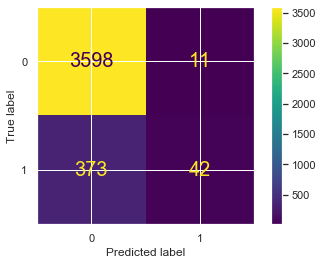

In [175]:
plot_confusion_matrix(RFC_model, X_test, y_test)  
plt.show()

### Hypertuning using RandomizedSeatchCV

In [160]:
# create a dictionary of all values we want to test for n_estimators
param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
             'max_depth': [2, 3, 4, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             'bootstrap': [False, True]}

#create a dictionary of all values we want to test for max_depth
#param_grid = {'max_depth': [2, 3, 4, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

# #create a dictionary of all values we want to test for bootstrap
#param_grid = {'bootstrap': [False, True]}

#use gridsearch to test all values for n_neighbors
RFC_gscv = RandomizedSearchCV(RFC_model, param_distributions=param_grid,
                               n_iter=1, n_jobs=4, cv=5, verbose=3)
#fit model to data
RFC_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.0s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=6),
                   n_iter=1, n_jobs=4,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [2, 3, 4, 6, 10, 20, 30,
                                                      40, 50, 60, 70, 80, 90,
                                                      100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 800, 1000]},
                   verbose=3)

In [161]:
RFC_gscv.best_params_

{'n_estimators': 400, 'max_depth': 3, 'bootstrap': True}

## =- XGBoost

In [14]:
XGB_model = XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1)
XGB_model.fit(X_train,y_train)

XGB_pred = XGB_model.predict(X_test)

results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test, XGB_pred)],
 "Precision" : [metrics.precision_score(y_test, XGB_pred)],
 "Recall" : [metrics.recall_score(y_test, XGB_pred)]})

results

,Accuracy,Precision,Recall
0,0.906561,0.714286,0.156627


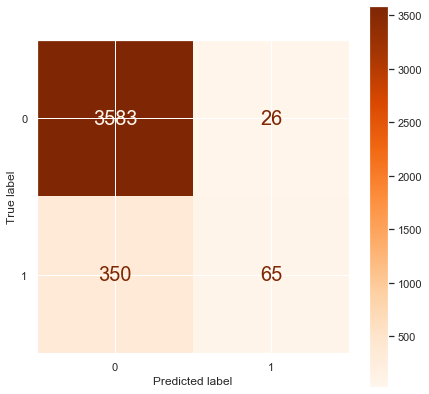

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(XGB_model, X_test, y_test, cmap=plt.cm.Oranges, ax=ax)
plt.show()

In [16]:
def calculate_roc_auc(model_, X_test_, y_test_):
    """
    Evaluate the roc-auc score
    """

    # Get the model predictions
    # Note that we are using the prediction for the class 1 -> churn
    prediction_test_ = model_.predict_proba(X_test_)[:,1]
    # Compute roc-auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)

    # Print the evaluation metrics as pandas dataframe
    score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
    return fpr, tpr, score

def plot_roc_auc(fpr,tpr): 
    """
    Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates.
    """

    # Initialize plot
    f, ax = plt.subplots(figsize=(14,8))

    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3,
    label="AUC = %0.2f" % (roc_auc))
    # Plot the random line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
    label="Random", alpha=.8)

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

fpr, tpr, auc_score = calculate_roc_auc(XGB_model, X_test, y_test)
auc_score

,ROC-AUC
0,0.681596


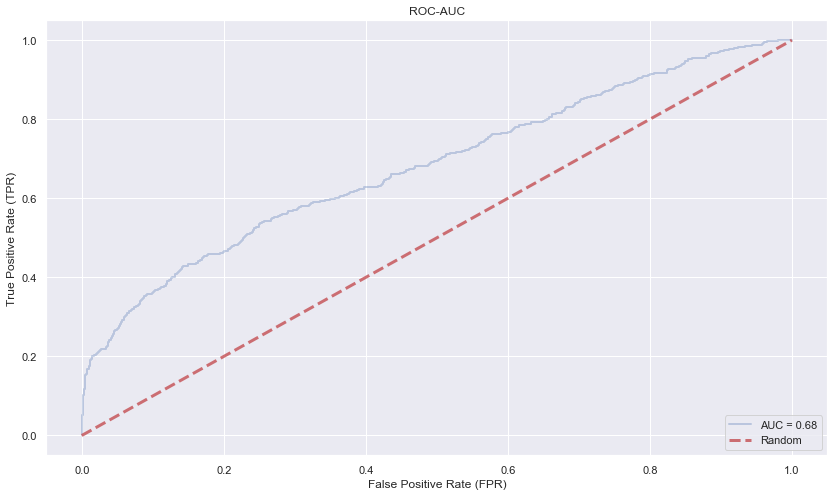

In [17]:
plot_roc_auc(fpr, tpr)
plt.show()

## Stratified K-fold validation

In [ ]:
def plot_roc_curve(fprs, tprs):
    """
    Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates.
    """

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(18,10))

 # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3,
        label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
    label="Random", alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=4, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
    label=r"$\pm$ 1 std. dev.")

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(model_, index):
    y_predict = model_.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

## Hyper-parameter Tuning 

### =-using RandomSearchCV

In [26]:
# Create the random grid
params = {
 'min_child_weight': [i for i in np.arange(1,15,1)],
 'gamma': [i for i in np.arange(0,6,0.5)],
 'subsample': [i for i in np.arange(0,1.1,0.1)],
 'colsample_bytree': [i for i in np.arange(0,1.1,0.1)],
 'max_depth': [i for i in np.arange(1,15,1)],
 'scale_pos_weight':[i for i in np.arange(1,15,1)],
 'learning_rate': [i for i in np.arange(0,0.15,0.01)],
 'n_estimators' : [i for i in np.arange(0,2000,100)]
 }

# Create model   
XGB_RSCV_model = XGBClassifier(objective='binary:logistic',silent=True, nthread=1)
                       
# Random search of parameters, using 5
XGB_RSCV = RandomizedSearchCV(XGB_RSCV_model, param_distributions=params,
                               n_iter=1, scoring= "roc_auc",
                               n_jobs=4, cv=5, verbose=3, random_state=1001)

# Fit the random search model
XGB_RSCV.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.9s finished


[16:11:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [27]:
best_param_rscv = XGB_RSCV.best_params_

In [40]:
best_param_rscv= {'subsample': 0.8,
'scale_pos_weight': 1,
'n_estimators': 1100,
'min_child_weight': 1,
'max_depth': 12,
'learning_rate': 0.01,
'gamma': 4.0,
'colsample_bytree': 0.60}


## XGB Classifier with best parameters using RandomSearchCV

In [41]:
# Create a model with the parameters found    
best_param_RSCV_model = XGBClassifier(objective='binary:logistic', silent=True, nthread=1,**best_param_rscv)

[16:28:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

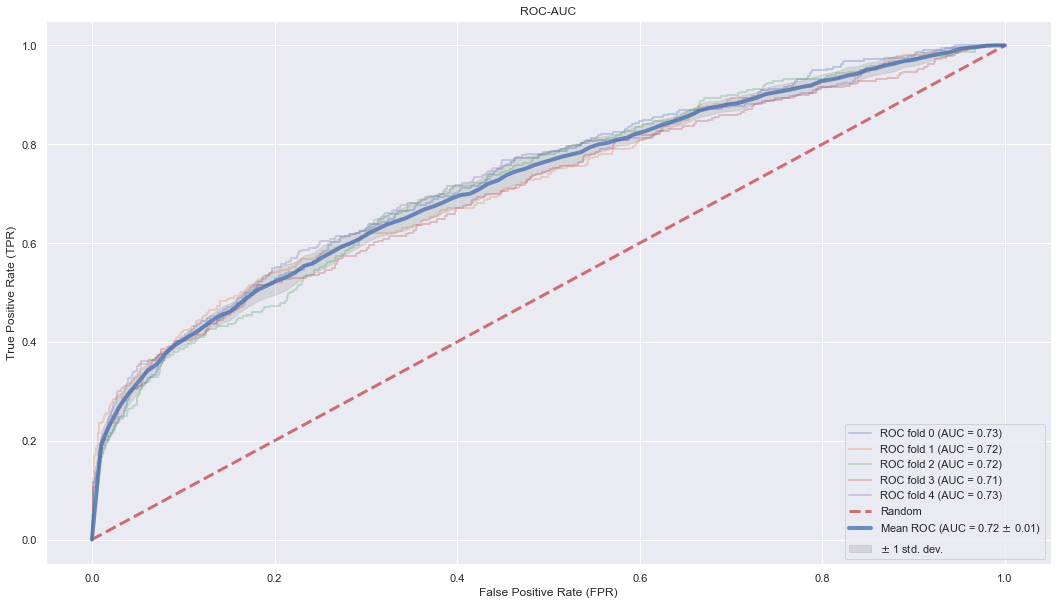

In [42]:

fprs, tprs, scores = [], [], []
for (train, test), i in zip(cv.split(X, y), range(5)):
    best_param_RSCV_model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(best_param_RSCV_model, train)
    fpr, tpr, auc_score = compute_roc_auc(best_param_RSCV_model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    

plot_roc_curve(fprs, tprs)
plt.show() 

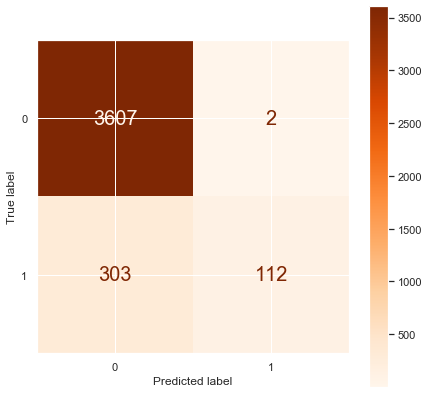

In [43]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(best_param_RSCV_model, X_test, y_test, cmap=plt.cm.Oranges, ax=ax)
plt.show()

### =- Using GridSearch

In [44]:
from sklearn.model_selection import GridSearchCV

params = {'subsample': [0.7],
          'scale_pos_weight': [1],
          'n_estimators': [1100],
          'min_child_weight': [1],
          'max_depth': [12, 13, 14],
          'learning_rate': [0.005, 0.01],
          'gamma': [4.0],
          'colsample_bytree': [0.6]
         }

XGB_GSCV_model = XGBClassifier(objective='binary:logistic', silent=True, nthread=1)

XGB_GSCV = GridSearchCV(estimator =XGB_GSCV_model, params, scoring= "roc_auc",
                       cv = 5, n_jobs = -1, verbose = 2)

#fit model to data
XGB_GSCV.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.7min finished


[17:00:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, silent=True,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbos

In [48]:
best_parameters =XGB_GSCV.best_params_

## XGB classifier using GSCV best parameters

[17:06:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

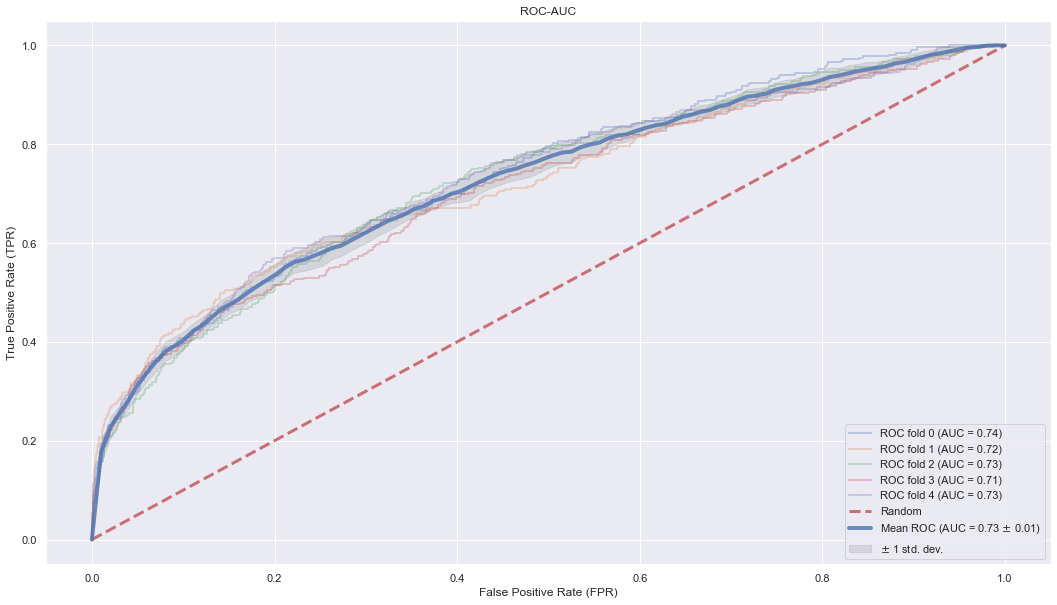

In [49]:

best_param_XGB_GSCV_model = XGBClassifier(objective='binary:logistic',
                                         silent=True, nthread=1, **best_parameters)

fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    best_param_XGB_GSCV_model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(best_param_XGB_GSCV_model, train)
    fpr, tpr, auc_score = compute_roc_auc(best_param_XGB_GSCV_model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curve(fprs, tprs)
plt.show()

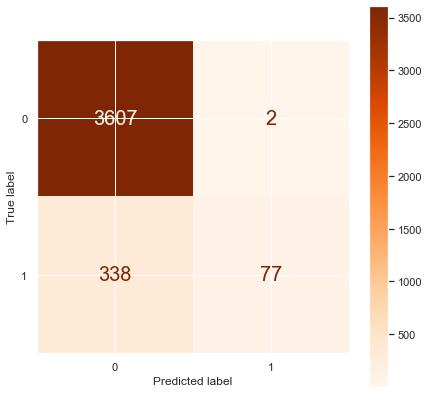

In [50]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(best_param_XGB_GSCV_model, X_test, y_test, cmap=plt.cm.Oranges, ax=ax)
plt.show()

# Interpreting Result

### What are the important features for the ML mode

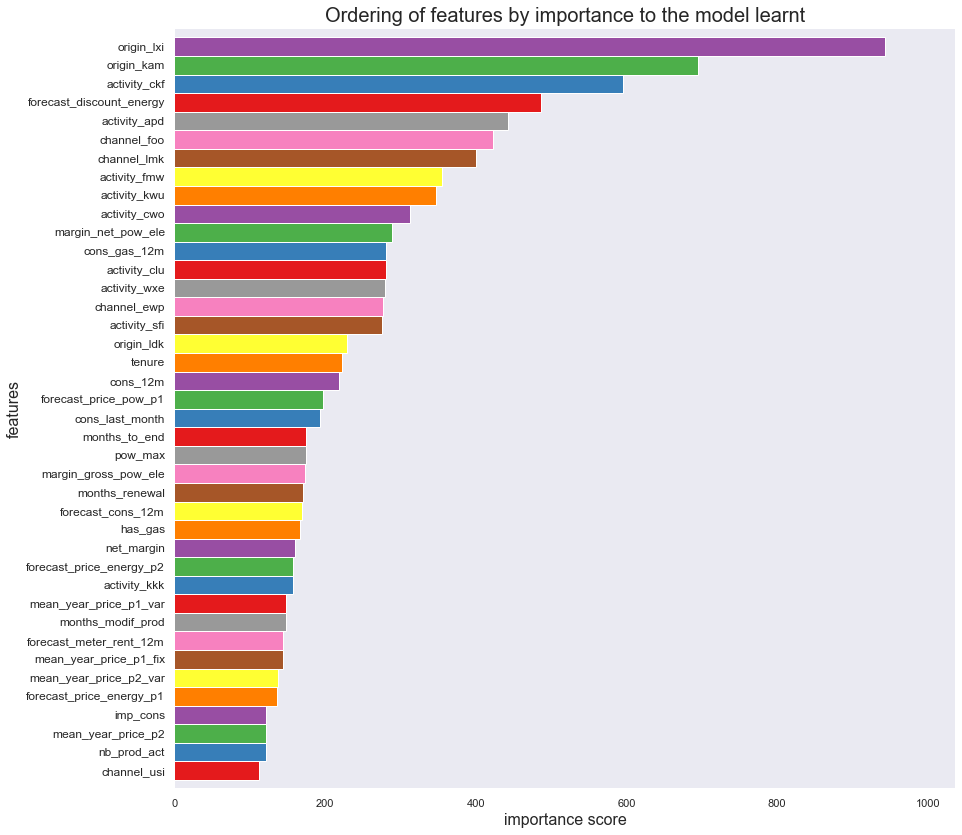

In [53]:
fig = plt.figure(figsize = (14, 14))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(best_param_RSCV_model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

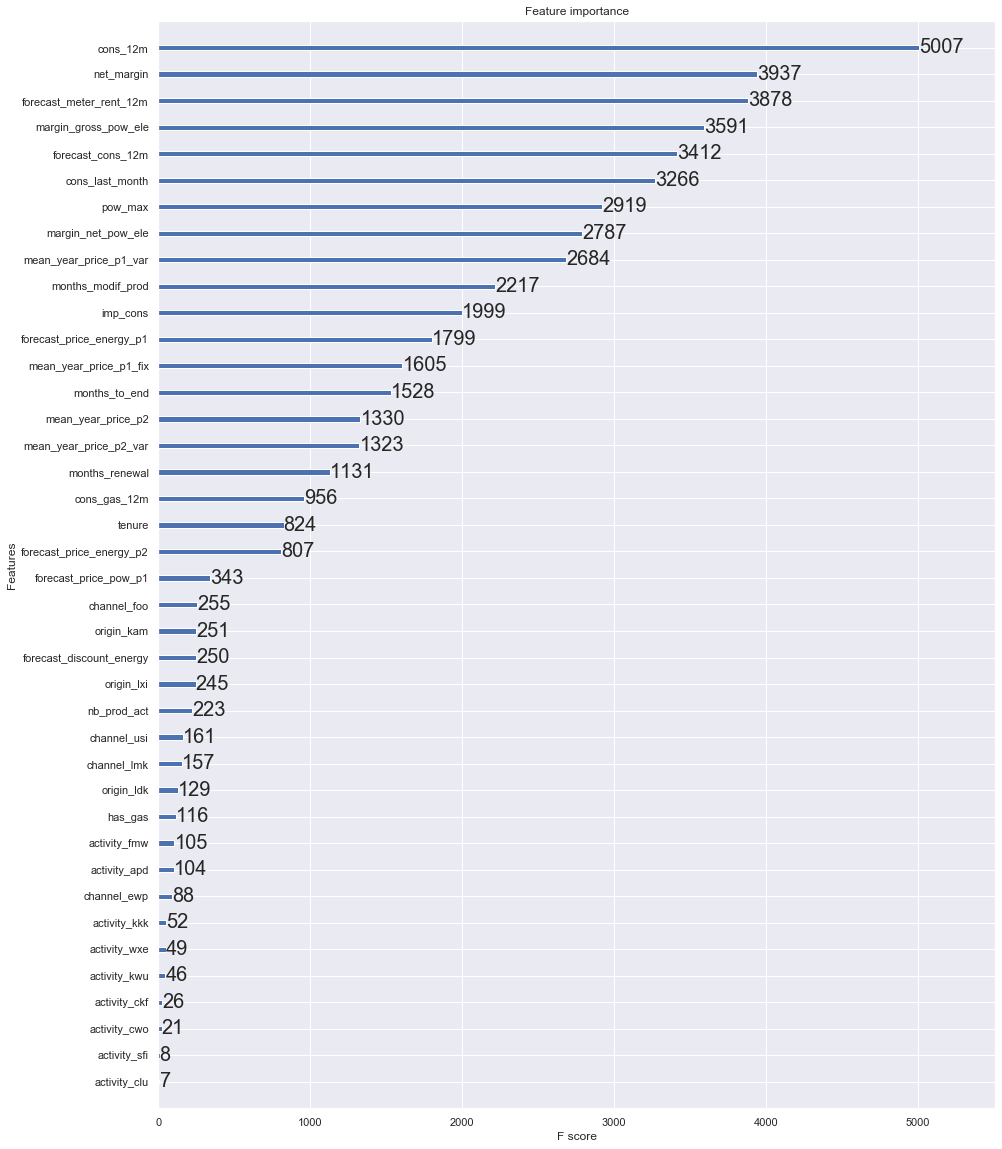

In [54]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(best_param_RSCV_model, ax=ax)

In the feature importance graph above we can see that cons_12m and net_margin are the features that appear the most in our model and
we could infere that these two features have a significant importnace in our model


## Partial dependence plot

The fig parameter is deprecated in version 0.22 and will be removed in version 0.24


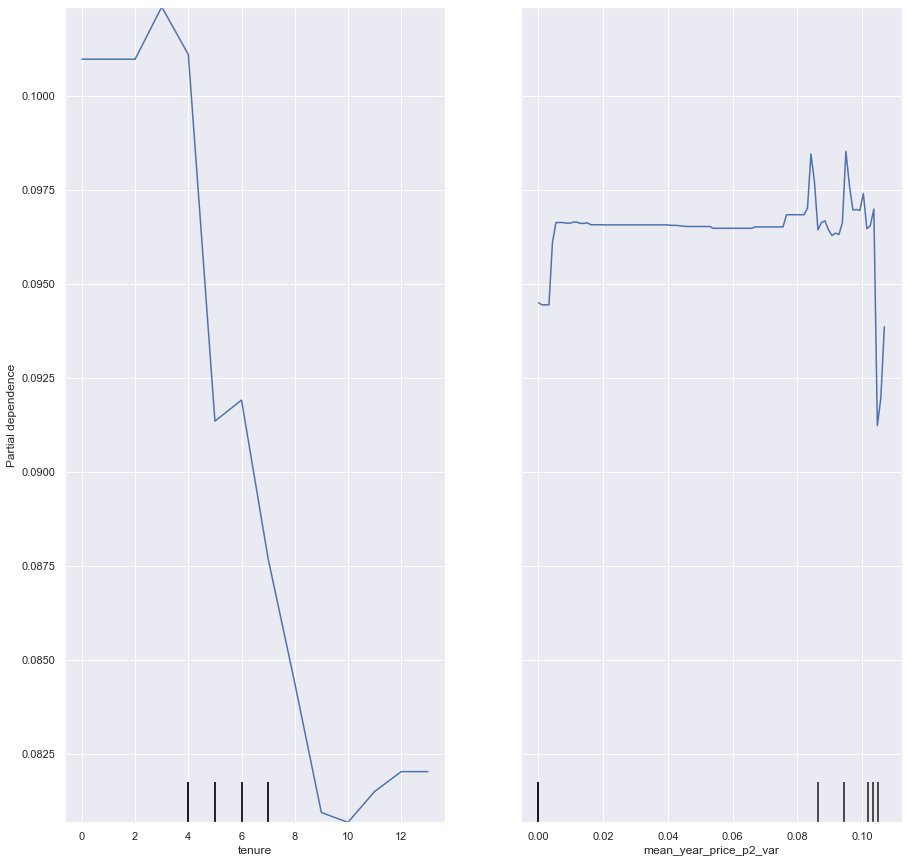

In [55]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(15,15))
plot_partial_dependence(best_param_RSCV_model, X_test.values,
                        features=[16, 42],
                        feature_names=X_test.columns.tolist(),
                        fig=fig) 

Comparing the PDP plots with respect to our previous models, we can see how they are slightly different. 

<b>tenure</b>

The overall trend is unchaged as compared to our previous models. We can see the trend spikes at slighly different times of the tenure ( 6y ) but then it goes down again and bottoms around 10 years. Then, it starts recovering a bit.

<b>mean_year_price_p2</b>

We see the pdp is flat with some spikes on the extreme values, which hints us that the variable mean_year_price_p2 is not very relevant in this model.


## SHAP - Feature importance

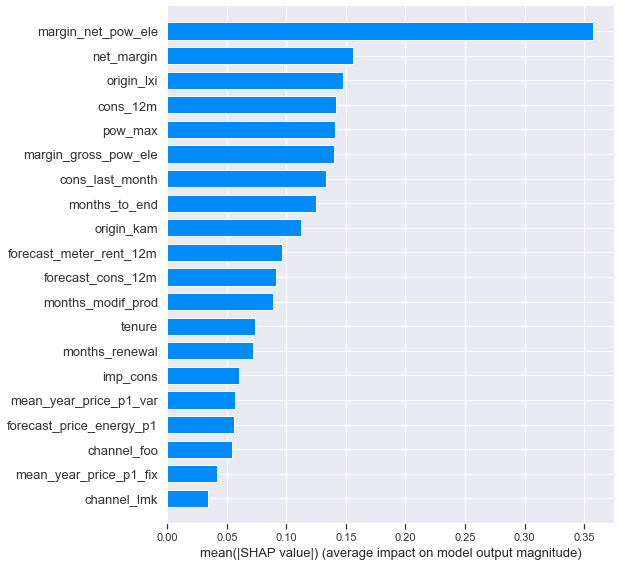

In [56]:
import shap

explainer = shap.TreeExplainer(best_param_RSCV_model)
shap_values = explainer.shap_values(X_test)

# Feature importance for class 1 - churn
shap.summary_plot(shap_values, X_test, plot_type='bar')

margin_net_pow_ele is the most important feature by far.

# Pickle Model

In [98]:
# Save to file in the current working directory
pkl_filename = "XGB_GSCV_classifier.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_param_XGB_GSCV_model, file)

NameError: name 'best_param_XGB_GSCV_model' is not defined

# Impact of discount

In [60]:
# Load feature matrix + predictions from pickle
XGB_Class = pickle.load(open('XGB_RSCV_classifier.pkl', 'rb'))
predic = XGB_Class.predict(X_test)
pred_prb = XGB_Class.predict_proba(X_test)

results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test, predic)],
 "Precision" : [metrics.precision_score(y_test, predic)],
 "Recall" : [metrics.recall_score(y_test, predic)]})

results

,Accuracy,Precision,Recall
0,0.924205,0.982456,0.26988


In [61]:
predic = pd.DataFrame(predic)
predic = predic.rename(columns={0: 'churn'})

#converting model probability prediction's array to dataframe & Rename columns of 0 and 1 probability 
pred_prb = pd.DataFrame(pred_prb)
pred_prb = pred_prb.rename(columns={0: 'predict_prob0', 1: 'predict_prob1'})

In [62]:
filter0 = pred_prb['predict_prob0'] > 0.5
filter1 = pred_prb['predict_prob1'] > 0.5

#process 0 and 1 probability columns into as 
#probaability of 0 columns values will have values in range 0 - 0.5 ,
#while probability of 1 column values will have between 0.5 - 1.0  
pred_prb.where(filter0 | filter1, inplace=True)

pred_prb['predict_prob1'].replace(pred_prb['predict_prob1'].where(pred_prb['predict_prob1']< 0.5), 0 , inplace=True)
pred_prb['predict_prob0'].replace(pred_prb['predict_prob0'].where(pred_prb['predict_prob0']< 0.5), 0 , inplace=True)

pred_prb['predict_prob0'] = 1- pred_prb['predict_prob0']
pred_prb['predict_prob0'].replace(pred_prb['predict_prob0'].where(pred_prb['predict_prob0']== 1.0), 0 , inplace=True)

pred_prb['predict_prob'] = pred_prb['predict_prob1'] + pred_prb['predict_prob0']
pred_prb.drop(columns=['predict_prob0', 'predict_prob1'], axis=1, inplace=True)


predictions = pd.concat([X_test.reset_index(drop=True), predic, pred_prb], axis=1)

In [78]:
#sort values according to the prediction probability values (descending)
predictions.sort_values(by='predict_prob', ascending=False, inplace=True)
predictions.reset_index(inplace=True, drop=True)
predictions

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,tenure,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p1_fix,mean_year_price_p2,churn,predict_prob,basecase_revenue,basecase_revenue_after_churn,discount_revenue,revenue_delta
0,4.045714,0.000000,0.000000,3.212076,0.299190,1.311118,0.135901,0.052951,43.533496,0,0.000000,29.760000,29.76,0.301030,2.195485,1.152288,4,8.0,5.0,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.146413,0.000000,44.355820,0.000000,1,0.927239,222.772009,32.940807,32.940807,0.0
1,4.085326,0.000000,0.000000,3.324470,0.299190,1.307496,0.135901,0.052951,43.533496,0,0.000000,39.720000,39.72,0.477121,2.969090,1.152288,4,6.0,5.0,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.175525,0.000000,45.194710,0.000000,1,0.911348,288.181421,46.821123,46.821123,0.0
2,5.057190,5.034540,3.913390,4.145682,0.002479,2.227218,0.148299,0.125137,41.105201,1,2.990223,20.962039,96.16,0.477121,3.238410,1.556303,3,5.0,0.0,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.153879,0.129497,41.160171,25.025265,1,0.908844,2076.282161,342.112987,342.112987,0.0
3,3.196729,0.000000,0.000000,2.375846,0.299190,1.310906,0.135901,0.052951,43.533496,0,0.000000,34.680000,34.68,0.301030,1.418301,1.171902,5,6.0,53.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.149667,0.007124,44.326190,0.007124,1,0.905989,33.600887,5.624670,5.624670,0.0
4,4.974014,0.000000,3.956168,2.306918,0.000000,1.171726,0.144902,0.000000,44.311378,0,1.278754,26.040000,26.04,0.301030,1.318272,1.056600,6,4.0,67.0,7,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.148958,0.000000,44.370635,0.000000,1,0.900000,30.547709,6.259680,6.259680,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,6.522346,5.938481,5.707423,3.213720,0.000000,2.124276,0.112860,0.096521,40.606701,1,2.258733,23.880000,23.88,0.477121,2.222820,1.431364,5,5.0,54.0,5,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.122274,0.098569,40.942265,22.450580,0,0.003238,186.736150,186.180545,186.180545,0.0
4020,6.550264,0.760466,5.587115,2.816930,0.000000,2.122871,0.115237,0.100123,40.939027,1,1.775028,29.640000,29.64,0.477121,1.863620,1.414973,5,10.0,49.0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.124068,0.103734,40.607325,24.479237,0,0.003182,77.722952,77.495675,77.495675,0.0
4021,6.522346,5.938481,5.707423,3.283747,0.000000,1.278754,0.144631,0.000000,44.311378,1,2.574217,8.800000,8.80,0.477121,2.208334,1.152288,6,9.0,62.0,2,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.147787,0.007124,44.341005,0.007124,0,0.002815,279.255197,278.532791,278.532791,0.0
4022,6.390862,5.735624,5.537833,2.086004,0.000000,2.164204,0.116910,0.100572,40.606701,1,1.604874,22.310000,22.31,1.000000,1.122544,1.243038,6,6.0,65.0,5,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.125474,0.104933,40.633851,24.485243,0,0.002761,16.415533,16.373880,16.373880,0.0


In [77]:
#probaabilities with values in between 0.5 to 0.8 will be replace by 0.9 as they all hit true class
con1 = predictions['predict_prob']> 0.5
con2 = predictions['predict_prob']< 0.9
predictions['predict_prob'].replace(predictions['predict_prob'].where(con1 & con2), 0.9 , inplace=True)


# Baseline revenue estimate

Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast price and actual churn outcome. Call this basecase_revenue

* For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year). Call this new variable basecase_revenue_after_churn , ie basecase_revenue_after_churn = basecase_revenue*(1-0.919*churn)

In [79]:
predictions['basecase_revenue'] = ((np.power(10, predictions['forecast_cons_12m']) 
                                   
                                    +1) * predictions['forecast_price_energy_p1']) + predictions['forecast_meter_rent_12m']
# Taking churn into account
predictions['basecase_revenue_after_churn'] = predictions['basecase_revenue'] * (1 - 0.919 * predictions['churn'])

# Estimated benefits and costs of intervention

Now, pick a cut-off probability (eg 0.5) so that:

* Customers with a higher churn probability than the cut-off get a discount, and
* Customers below the churn-probability get a discount.

From this, calculate the revenue of the intervention scenario of this scenario assuming:

* All customers who are offered a discount accept it
* Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability=0), and therefore the retained revenue is 0.8*basecase_revenue , being (1-discount_fraction)*basecase_revenue
* Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually churned or not).

Now, map out the revenue delta as a function of the cut-off probability in a graph

What cut-off probability approximately optimises the revenue outcome?

Assume for these calculations that the customer does not consume more or less electricity because the price changes. (In practice, we would expect that if the customer's cost goes down then their consumption might increase.)

We will see two counterbalancing effects at play:

* For true postives we will see revenue retention vs the no-discount scenario
* For false positives we will see reduced revenue from giving them a discount when they wouldn't in fact churn.

(False negatives represent an opportunity cost but not an actual cost difference between the two scenarios.)

The optimal cut-off point will balance the benefits from true positives against the costs of false positives.

Our task is to approximately find the optimal cut-off point. We may need to make additional assumptions. If we feel the assumptions above aren't justified and that others are better then we should modify our assumptions.

In [80]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['predict_prob'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

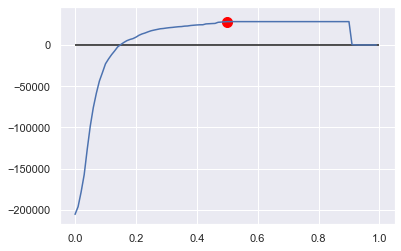

Maximum benefit at cutoff 0.5 with revenue delta of $28,277.12


In [81]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(predictions, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})

def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')
plot_tradeoff(rev_deltas)


# Selecting cut-off

Above, we decided who to offer the discount to based on a probability cut-off.

Is this the optimal strategy?

* For instance, we might be offering discounts to customers who are not very profitable, thus worsening our overall margins substantially. For
example, if offering a discount makes the customer unprofitable on a net margin basis then we might want to let them churn rather than save them.
* Even if we only consider revenue, this strategy might not be optimal from a revenue viewpoint. For instance, we can calculate the expected revenue impact of our strategy and prioritise customers for discounts that have a high expected revenue impact. (This means that the probability of churn might be high but they also might be valuable customers).

A general principle here is that we can afford to spend more on retaining high-value customers because the costs of losing them are higher.

A very common mistake in business applications of churn is to focus on the churn probability whilst forgetting the value impact (to greater or lesser
extents). We have seen many cases where our clients spend as much effort on retaining unprofitable customers as they do on retaining highly
profitable customers.

In [82]:
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2, min_rev: float=500) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff and rev
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given for high-value customers => customer stays for full year, independent
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[(pred['predict_prob'] >= cutoff) & (pred['basecase_revenue'] > min_rev),
             'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

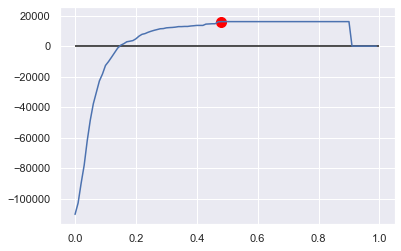

Maximum benefit at cutoff 0.48 with revenue delta of $16,075.08


In [83]:
#Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(predictions, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
                                   
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

# Using forecast rather than actual churn

We may have noticed above that we used actual churn outcomes in calculating the financial impact. Actual churn outcomes are fine if we know them and are conducting a retrospective analysis of the effectiveness of a strategy. This example of analysis is commonly known as "backtesting", ie seeing how well a strategy would have performed historically.

(Of course, one must be careful that any analysis is done using out-of-sample data. Conducting the analysis on the training data will lead to predictions that are too optimistic.)

In practice, actual outcomes may not be available because they are in the future.

An alternative is to optimise predicted/forecast revenue based on the probabilities which are an output from our churn model. In this case, we would replace the actual churn outcomes ( churn ) with the predicted probability of churn from our model. The results here are obviously model-dependent.

If our model probabilities are poorly calibrated then we can end up with quite poor results from this. Going down this path therefore usually requires
the extra step of checking how well calibrated the model probabilities are, and potentially correcting for any miscalibration using Platt scaling or
isotonic regression.


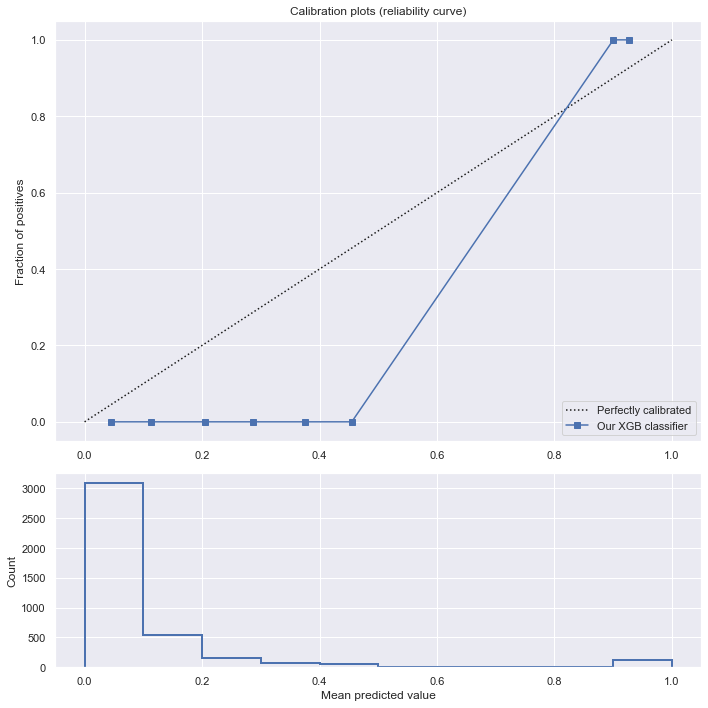

In [85]:
from sklearn.calibration import calibration_curve
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true=predictions['churn'],
                                                                y_prob=predictions['predict_prob'],
                                                                n_bins=12)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Our XGB classifier")
ax2.hist(predictions['predict_prob'], range=(0, 1), bins=10, histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
plt.tight_layout()

To use the predicted churn probability, we simply need to replace all 1/0 churn values with it in all calculations:


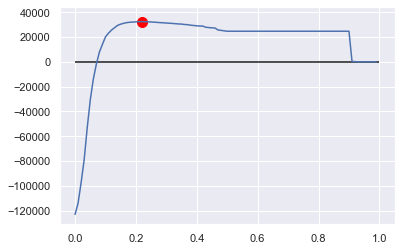

Maximum benefit at cutoff 0.22 with revenue delta of $32,451.60


In [86]:
predictions['basecase_revenue'] = (
    np.power(10, predictions['forecast_cons_12m']) * predictions['forecast_price_energy_p1']) + predictions['forecast_meter_rent_12m']

# Taking churn into account
predictions['basecase_revenue_after_churn'] = predictions['basecase_revenue'] * (1 - 0.919 * predictions['predict_prob'])

def get_rev_delta_proba(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['predict_prob'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()
                                                                                                         
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(predictions, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
plot_tradeoff(rev_deltas)

# Selecting Discount

In the strategy suggested by the SME division head we offer a 20% discount to all customer targeted. However, this might not be optimal either.

We assumed before that customers offered a discount will not churn. However, that may not be true in reality. The discount may not be large enough to prevent churn.

In fact, we can predict the churn probability for each customer as a function of price, margin and other factors. Therefore, we can try to find a strategy for each customer that optimises either their expected revenue or profit.

In order to go further, we'll need to try to:

* Change the level of discount offered overall
* Predict the response of customers to that discount (ie, the churn probability) based on how much that discount affects their prices, the revenue and margin.
    
     * Take care that we've applied the discount to all affected variables. To make this easier, we might want to retrain our model using a simpler set of variables where we know that we can factor the discount correctly into the predictors.
    
* Find the discount level that balances customer retention vs the cost of false positives.
    
In fact, this could be turned into a 2D optimisation problem:

* Objective: maximise net revenue (ie including the benefits of true positives and the cost of false positives)
* Decision variables
    
     * Level of discount offered, and
     * Fraction of people who are offered a discount
        
An even more sophisticated strategy is to find the right level of discount for each customer that maximises their predicted revenue or margin.
